In [1]:
from __future__ import division, print_function
% pylab inline
import math
import numpy
from numpy.fft import fft2, ifft2, fftshift
import IP
try:
    import scipy.ndimage.interpolation as ndii
except ImportError:
    import ndimage.interpolation as ndii


Populating the interactive namespace from numpy and matplotlib


In [2]:
def highpass(shape):
    """Return highpass filter to be multiplied with fourier transform."""
    x = outer(
        cos(linspace(-pi/2., pi/2., shape[0])),
        cos(linspace(-pi/2., pi/2., shape[1])))
    return (1.0 - x) * (2.0 - x)

In [71]:
def logpolar(image, angles=None, radii=None):
    """Return log-polar transformed image and log base."""
    shape = image.shape
    center = shape[0] / 2, shape[1] / 2
    if angles is None:
        angles = shape[0]
    if radii is None:
        radii = shape[1]
    theta = empty((angles, radii), dtype=float64)
    theta.T[:] = -linspace(0,pi, angles, endpoint=False)
    #d = radii
    d = hypot(shape[0]-center[0], shape[1]-center[1])
    log_base = 10.0 ** (log10(d) / (radii))
    radius = empty_like(theta)
    radius[:] = power(log_base, arange(radii,dtype=numpy.float64)) - 1.0
    x = radius * sin(theta) + center[0]
    y = radius * cos(theta) + center[1]
    output = empty_like(x)
    ndii.map_coordinates(image, [x, y], output=output)
    return output, log_base

In [58]:
def similarity(im0, im1):
    """Return similarity transformed image im1 and transformation parameters.

    Transformation parameters are: isotropic scale factor, rotation angle (in
    degrees), and translation vector.

    A similarity transformation is an affine transformation with isotropic
    scale and without shear.

    Limitations:
    Image shapes must be equal and square.
    All image areas must have same scale, rotation, and shift.
    Scale change must be less than 1.8.
    No subpixel precision.

    """
    if im0.shape != im1.shape:
        raise ValueError("Images must have same shapes.")
    elif len(im0.shape) != 2:
        raise ValueError("Images must be 2 dimensional.")

    f0 = fftshift(abs(fft2(im0)))
    f1 = fftshift(abs(fft2(im1)))

    h = highpass(f0.shape)
    f0 *= h
    f1 *= h
    del h

    f0, log_base = logpolar(f0)
    f1, log_base = logpolar(f1)

    f0 = fft2(f0)
    f1 = fft2(f1)
    r0 = abs(f0) * abs(f1)
    ir = abs(ifft2((f0 * f1.conjugate()) / r0))
    i0, i1 = unravel_index(argmax(ir), ir.shape)
    angle = 180.0 * i0 / ir.shape[0]
    scale = log_base ** i1

    if scale > 1.8:
        ir = abs(ifft2((f1 * f0.conjugate()) / r0))
        i0, i1 = unravel_index(argmax(ir), ir.shape)
        angle = -180.0 * i0 / ir.shape[0]
        scale = 1.0 / (log_base ** i1)
        if scale > 1.8:
            raise ValueError("Images are not compatible. Scale change > 1.8")

    if angle < -90.0:
        angle += 180.0
    elif angle > 90.0:
        angle -= 180.0

    im2 = ndii.zoom(im1, 1.0/scale)
    im2 = ndii.rotate(im2, angle)

    if im2.shape < im0.shape:
        t = zeros_like(im0)
        t[:im2.shape[0], :im2.shape[1]] = im2
        im2 = t
    elif im2.shape > im0.shape:
        im2 = im2[:im0.shape[0], :im0.shape[1]]
    
    # The segment below is for translation
    f0 = fft2(im0)
    f1 = fft2(im2)
    ir = abs(ifft2((f0 * f1.conjugate()) / (abs(f0) * abs(f1))))
    t0, t1 = unravel_index(argmax(ir), ir.shape)

    if t0 > f0.shape[0] // 2:
        t0 -= f0.shape[0]
    if t1 > f0.shape[1] // 2:
        t1 -= f0.shape[1]

    im2 = ndii.shift(im2, [t0, t1])

    # correct parameters for ndimage's internal processing
    if angle > 0.0:
        d = int((int(im1.shape[1] / scale) * sin(radians(angle))))
        t0, t1 = t1, d+t0
    elif angle < 0.0:
        d = int((int(im1.shape[0] / scale) * sin(radians(angle))))
        t0, t1 = d+t1, d+t0
    scale = (im1.shape[1] - 1) / (int(im1.shape[1] / scale) - 1)

    return im2, scale, angle, [-t0, -t1]


In [26]:

def imshow(im0, im1, im2, im3=None, cmap=None, **kwargs):
    """Plot images using matplotlib."""
    from matplotlib import pyplot
    if cmap is None:
        cmap = 'coolwarm'
    if im3 is None:
        im3 = abs(im2 - im0)
    pyplot.subplot(221)
    pyplot.imshow(im0, cmap, **kwargs)
    pyplot.subplot(222)
    pyplot.imshow(im1, cmap, **kwargs)
    pyplot.subplot(223)
    pyplot.imshow(im3, cmap, **kwargs)
    pyplot.subplot(224)
    pyplot.imshow(im2, cmap, **kwargs)
    pyplot.show()

In [96]:
I1 = IP.rgb2gray(IP.imread('mid_desk.jpg'))
I2 = IP.rgb2gray(IP.imread('home2.jpg'))
I3 = IP.rgb2gray(IP.imread('darkest_desk.jpg'))

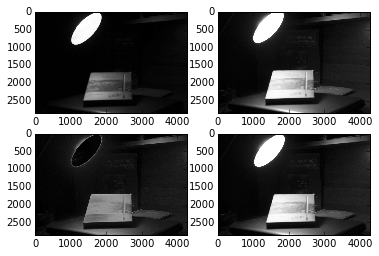

In [97]:
im2, scale, angle, (t0, t1) = similarity(I3,I1)
imshow(I3,I1,im2,cmap='gray')

In [99]:
t1

-28

In [72]:
I4 = IP.rgb2gray(IP.imread('book_bright.jpg'))
I5 = IP.rgb2gray(IP.imread('book_dark.jpg'))

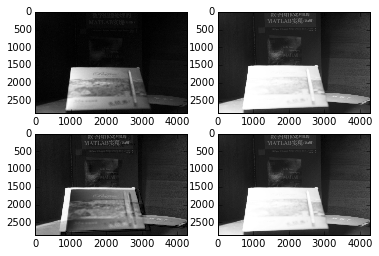

In [86]:
im3, scale3, angle3, (t2, t3) = similarity(I5,I4)
imshow(I5,I4,im3,cmap='gray')

In [95]:
t3

0